# Playground

## Import packages

In [1]:
%reload_ext autoreload
%reload_ext tensorboard

# simulation 
import simulator as sim

# data manipulation
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt

# isolation forest
from sklearn.ensemble import IsolationForest

# gan
import gan as g
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, Input
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam

from datetime import datetime

# evaluation 
from sklearn.metrics import confusion_matrix, precision_score, recall_score

## Sensor and anomaly simulation

### Define values

In [179]:
features = 1  # nbr of time series
series_length = 100  # nbr of simulations
lag = 3  # lag for the ar-series
anomaly_amp = 5
anomaly_freq = 0.01
season_amp = 10  # amplitude of seasonal component
season_period = 20  # season period
e = 0

### Set AR-matrices

In [180]:
ar = np.zeros((features, features))
constant = np.zeros(features)
trend = np.zeros(features)

In [181]:
# first time series
ar[0, 0] = 0

constant[0] = 0
trend[0] = 0

In [161]:
# second time series
ar[0, 1] = 0
ar[1, 0] = 0
ar[1, 1] = 1

constant[1] = 0
trend[1] = 0

IndexError: index 1 is out of bounds for axis 1 with size 1

In [162]:
# third time series
ar[1, 2] = 0
ar[2, 0] = 0
ar[2, 1] = 0
ar[2, 2] = 1

constant[2] = 0
trend[2] = 0

IndexError: index 1 is out of bounds for axis 0 with size 1

### Simulate sensor data

In [163]:
#sensor_df = pd.DataFrame(sensor, index=time)
#anomaly_df = pd.DataFrame(index=time)
#anomaly_df['Point anomaly'] = pd.Series(
#    sim.point_anomaly(anomaly_freq, features, anomaly_amp))
#anomaly_df['Trend anomaly'] = pd.Series(trend_anomaly(0.01, n_sim, 20, 3))

#sensor_df[0] = sensor_df[0] + anomaly_df[
#    'Point anomaly']  # add point anomalies to first time series
#sensor_df.fillna('0')

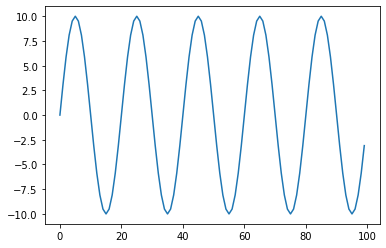

In [182]:
sensor = sim.sensor_simulation(series_length, features, ar, lag, constant, trend, e,
                               season_amp, season_period)
time = np.linspace(0, series_length - 1, series_length)
plt.plot(sensor);

#### Alternative simulation

In [16]:
#empty = np.zeros((150,2))
#model = VARMAX(empty, order=(1, 0), trend='c')

# [trend, trend, ar11, ar12, ar22, ar21, sigma]
#simulations = model.simulate([1, A[0,0], 0, 0, 0.5, 0, 0.1], 150)

#empty = np.zeros(150)
#model = SARIMAX(empty, order=(1, 0, 0), trend='c')
#simulations = model.simulate([1, 0.9, 0.1], 150)
#plt.plot(simulations)

## Models

### Isolation Forest

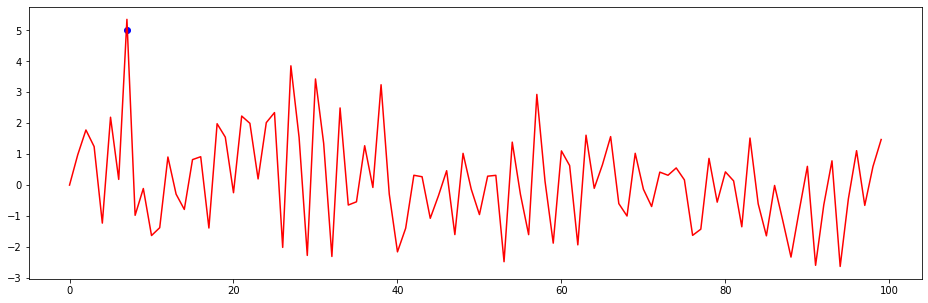

In [11]:
model = IsolationForest(n_estimators=100,
                        contamination=0.01,
                        max_samples='auto',
                        behaviour='new')
model.fit(sensor_df)
anomaly_df['Predicted anomaly'] = pd.Series(model.predict(sensor_df))
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sensor_df[0], color='red')

a = anomaly_df.loc[anomaly_df['Predicted anomaly'] == -1,
                   ['Point anomaly']]  #anomaly
ax.scatter(a.index, a['Point anomaly'], color='blue');

### GAN

#### Generate series and split into sequences

In [183]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        out_end_ix = end_ix + 1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 

In [193]:
#series_length = 50
#features = 3
timesteps = 40
samples = series_length - timesteps

In [194]:
X_tr, y = split_sequences(sensor, timesteps)

#### Create GAN

In [195]:
# Creating GAN
generator = g.create_generator(timesteps, features)
discriminator = g.create_discriminator(timesteps, features)
gan = g.create_gan(discriminator, generator, timesteps, features)

In [204]:
# Generate samples from the random space
Z = np.random.normal(0,1, [samples, timesteps, features])
G_z = generator.predict(Z)
            
# Get the sampled real series
X = X_tr
d_x = discriminator.predict(X)
d_g = discriminator.predict(G_z)

In [209]:
discriminator.trainable=True
d_loss = discriminator.train_on_batch(d_x, d_g)

ValueError: Error when checking input: expected lstm_34_input to have 3 dimensions, but got array with shape (60, 1)

In [196]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = keras.callbacks.TensorBoard(
  log_dir=logdir,
  histogram_freq=0,
  write_graph=True
)

In [197]:
tensorboard.set_model(gan)

In [198]:
def named_logs(model, logs):
  result = {}
  for l in zip(model.metrics_names, logs):
    result[l[0]] = l[1]
  return result

In [199]:
def plot_generated_series(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[4, timesteps, features])
    generated_series = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(generated_series.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.plot(generated_series[i])
        plt.axis('off')
    plt.tight_layout()

In [218]:
def training(X_train, samples, epochs=5):
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(samples)):
            
            # Generate samples from the random space
            Z = np.random.normal(0,1, [samples, timesteps, features])
            G_z = generator.predict(Z)
            
            # Get the sampled real series
            X = X_train
         
            #Construct different batches of  real and fake data 
            both = np.concatenate([X, G_z])

            # Labels for generated and real data
            y_dis = np.zeros(2*samples)
            y_dis[:samples] = 0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            d_loss = discriminator.train_on_batch(both, y_dis)
            
            #Tricking the noised input of the Generator as real data
            Z = np.random.normal(0,1, [samples, timesteps, features])
            y_gen = np.ones(samples)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable = False
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            g_loss = gan.train_on_batch(Z, y_gen)
            
            tensorboard.on_epoch_end(e, named_logs(gan, [g_loss]))
        if e == 1 or e % 2 == 0:
            plot_generated_series(e, generator)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 5


100%|██████████| 60/60 [00:59<00:00,  1.00it/s]


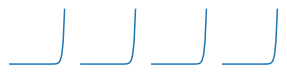

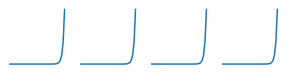

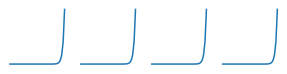

In [219]:
training(X_tr, samples)

In [175]:
%tensorboard --logdir=logdir --port=6007

Reusing TensorBoard on port 6007 (pid 19233), started 1:19:12 ago. (Use '!kill 19233' to kill it.)

## Evaluation

In [11]:
def eval(pred_anomaly_bool, anomaly_bool):
    confusion = confusion_matrix(pred_anomaly_bool, anomaly_bool)
    precision = precision_score(pred_anomaly_bool, anomaly_bool)        
    recall = recall_score(pred_anomaly_bool, anomaly_bool)
    return confusion, precision, recall

### Isolation Forest

In [12]:
if_pred_anomaly_bool = anomaly_df['Predicted anomaly'] == -1
if_anomaly_bool = (anomaly_df['Point anomaly'] != 0)

[c, p, e] = eval(if_pred_anomaly_bool, if_anomaly_bool)

NameError: name 'anomaly_df' is not defined